In [109]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

In [101]:
# Read the train and test data
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

# Drop columns with missing values
missing_percentages = train_data.isnull().mean() * 100
columns_to_drop = missing_percentages[missing_percentages >= 50].index
train_data.drop(columns_to_drop, axis=1, inplace=True)

# Fill missing values with default subjects
default_subject = 'No subject'
train_data['LotFrontage'] = train_data['LotFrontage'].fillna(default_subject)
train_data['FireplaceQu'] = train_data['FireplaceQu'].fillna(default_subject)

# Fill remaining missing values with 'N/A'
default_value = 'N/A'
train_data = train_data.fillna(default_value)



In [102]:
# Get the selected features
features = ['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'LotShape', 'LandContour', 'Utilities',
            'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
            'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st',
            'Exterior2nd', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
            'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
            'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
            'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
            'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
            'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
            'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SaleType',
            'SaleCondition']

# Prepare the training data
X = train_data[features]
y = train_data['SalePrice']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [103]:

# Encode categorical columns
categorical_columns = []
for column in train_data.columns:
    if train_data[column].dtype == 'object':
        categorical_columns.append(column)

encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_train_encoded = pd.DataFrame()
X_val_encoded = pd.DataFrame()

for column in categorical_columns:
    X_train[column] = X_train[column].astype(str)
    X_val[column] = X_val[column].astype(str)

    encoder.fit(X_train[[column]])
    X_train_column_encoded = pd.DataFrame(encoder.transform(X_train[[column]]))
    X_val_column_encoded = pd.DataFrame(encoder.transform(X_val[[column]]))

    X_train_encoded = pd.concat([X_train_encoded, X_train_column_encoded], axis=1)
    X_val_encoded = pd.concat([X_val_encoded, X_val_column_encoded], axis=1)

X_train_processed = pd.concat([X_train_encoded, X_train.drop(categorical_columns, axis=1)], axis=1)
X_val_processed = pd.concat([X_val_encoded, X_val.drop(categorical_columns, axis=1)], axis=1)
X_train_processed.columns = X_train_processed.columns.astype(str)
X_val_processed.columns = X_val_processed.columns.astype(str)

c:\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `spa

In [104]:
# Impute missing values
feature_imputer = SimpleImputer(strategy='mean')
X_train_imputed = feature_imputer.fit_transform(X_train_processed)
X_val_imputed = feature_imputer.transform(X_val_processed)

target_imputer = SimpleImputer(strategy='mean')
y_train_imputed = target_imputer.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_val_imputed = target_imputer.transform(y_val.values.reshape(-1, 1)).ravel()

X_train_imputed = X_train_imputed[:len(y_train_imputed)]
X_val_imputed = X_val_imputed[:len(y_val_imputed)]


In [105]:
# Train the Random Forest model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_imputed, y_train_imputed)

# Predict on the validation set
y_pred_rf = rf_model.predict(X_val_imputed)


In [106]:
# Truncate the longer array to match the length of the shorter array
min_len = min(len(y_val_imputed), len(y_pred_rf))
y_val_imputed = y_val_imputed[:min_len]
y_pred_rf = y_pred_rf[:min_len]

# Evaluate the Random Forest model
rmse_rf = np.sqrt(mean_squared_error(y_val_imputed, y_pred_rf))
print(f"Random Forest RMSE: {rmse_rf}")


Random Forest RMSE: 42763.537102052826


In [107]:
# Train the Gradient Boosting model
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train_encoded[:len(y_train)], y_train)

# Predict on the validation set
y_pred_gb = gb_model.predict(X_val_encoded)

# Truncate the longer array to match the length of the shorter array
min_len = min(len(y_val_imputed), len(y_pred_gb))
y_val_imputed = y_val_imputed[:min_len]
y_pred_gb = y_pred_gb[:min_len]

# Evaluate the Gradient Boosting model
rmse_gb = np.sqrt(mean_squared_error(y_val_imputed, y_pred_gb))
print(f"Gradient Boosting RMSE: {rmse_gb}")


Gradient Boosting RMSE: 39686.99385191995


In [ ]:

# Prepare the test data
X_test = test_data[features]

X_test_encoded = pd.DataFrame()
for column in categorical_columns:
    X_test[column] = X_test[column].astype(str)
    encoder.fit(X_train[[column]])
    X_test_column_encoded = pd.DataFrame(encoder.transform(X_test[[column]]))
    X_test_encoded = pd.concat([X_test_encoded, X_test_column_encoded], axis=1)

X_test_processed = pd.concat([X_test_encoded, X_test.drop(categorical_columns, axis=1)], axis=1)
X_test_processed.columns = X_test_processed.columns.astype(str)
X_test_imputed = feature_imputer.transform(X_test_processed)

# Make predictions on the test set
rf_test_predictions = rf_model.predict(X_test_imputed)
gb_test_predictions = gb_model.predict(X_test_encoded)

# Print the predictions
print("Random Forest Test Predictions:")
print(rf_test_predictions)
print("Gradient Boosting Test Predictions:")
print(gb_test_predictions)

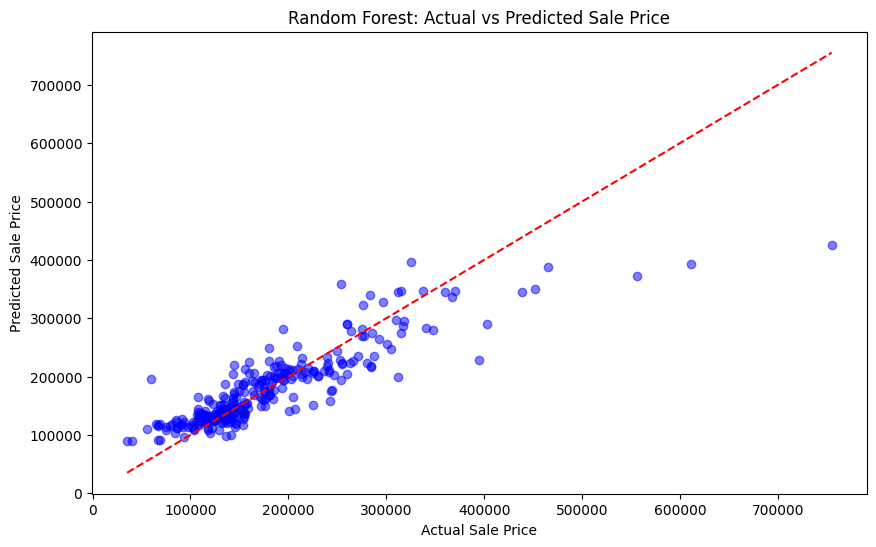

In [110]:


# Scatter plot for Random Forest model
plt.figure(figsize=(10, 6))
plt.scatter(y_val_imputed, y_pred_rf, color='blue', alpha=0.5)
plt.plot([min(y_val_imputed), max(y_val_imputed)], [min(y_val_imputed), max(y_val_imputed)], color='red', linestyle='--')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('Random Forest: Actual vs Predicted Sale Price')
plt.show()



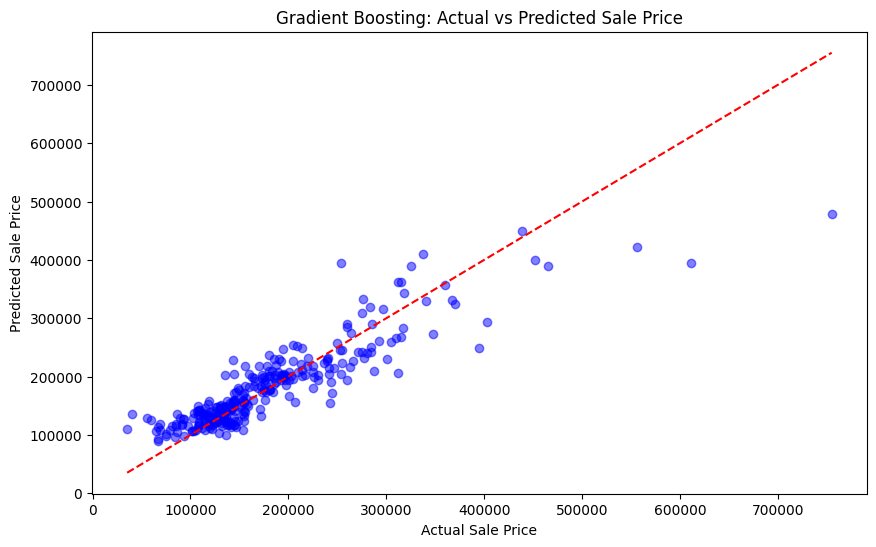

In [111]:
# Scatter plot for Gradient Boosting model
plt.figure(figsize=(10, 6))
plt.scatter(y_val_imputed, y_pred_gb, color='blue', alpha=0.5)
plt.plot([min(y_val_imputed), max(y_val_imputed)], [min(y_val_imputed), max(y_val_imputed)], color='red', linestyle='--')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('Gradient Boosting: Actual vs Predicted Sale Price')
plt.show()
